# Import

In [428]:
import numpy as np
import tensorflow as tf
import struct
from array import array
from os.path  import join
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.manifold import TSNE

In [429]:
from tensorflow.keras.optimizers.legacy import RMSprop
optimizer = RMSprop()

# MNIST

In [430]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

## Datensatz

In [431]:
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = "data/MNIST/train-images.idx3-ubyte"
        self.training_labels_filepath = "data/MNIST/train-labels.idx1-ubyte"
        self.test_images_filepath = "data/MNIST/t10k-images.idx3-ubyte"
        self.test_labels_filepath = "data/MNIST/t10k-labels.idx1-ubyte"
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 
    
#
# Set file paths based on added MNIST Datasets
#
input_path = '../input'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')    

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


print(np.shape(x_train),np.shape(y_train), np.shape(x_test), np.shape(y_test))

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [432]:
train_x = np.asarray(x_train)
train_y = np.asarray(y_train)
test_x = np.asarray(x_test)
test_y = np.asarray(y_test)

x_train = train_x.reshape(-1, 28, 28, 1).astype('float64') / 255
x_test = test_x.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(train_y, 10)
y_test = to_categorical(test_y, 10)

## Model trainieren

In [443]:
load_mnist_model = False

In [444]:
# Modellarchitektur für das CNN
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = tf.keras.layers.Activation('softmax', name='softmax')(logits)
    return Model(inputs=inputs, outputs=outputs)

# Funktion zum Erstellen von Paaren und deren Labels
def create_pairs(x, digit_indices):
    pairs = []
    labels = []

    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs.append([x[z1], x[z2]])
            labels.append(1)
            inc = np.random.randint(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs.append([x[z1], x[z2]])
            labels.append(0)
    return np.array(pairs), np.array(labels)

# Daten und Paare erstellen
digit_indices_train = [np.where(y_train == i)[0] for i in range(10)]
digit_indices_test = [np.where(y_test == i)[0] for i in range(10)]

# CNN-Modell erstellen
input_shape = x_train.shape[1:]

if load_mnist_model:
    cnn_model = tf.keras.models.load_model(os.path.join('./model_mnist/', 'cnn_model.h5'))
else:
    cnn_model = create_cnn_model(input_shape)
    # Training der CNN-Modell
    cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    cnn_model.fit(x_train, y_train, epochs=6, batch_size=256, verbose=1, validation_data=(x_test, y_test))
    if not os.path.exists('./model_mnist/'):
        os.makedirs('./model_mnist/')
    cnn_model.save(os.path.join('./model_mnist/', 'cnn_model.h5'))


tr_pairs, tr_y = create_pairs(x_train, digit_indices_train)
te_pairs, te_y = create_pairs(x_test, digit_indices_test)



In [445]:
encoder = tf.keras.models.Sequential(cnn_model.layers[:-3])
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 7, 7, 32)         

## Datensatz reduzieren

In [446]:
np.argmax(y_train[0])

5

In [447]:
# Umwandlung von y_train in ein NumPy-Array von Ganzzahlen
y_train_integer = np.argmax(y_train, axis=1)
# Jetzt den reduzierten Datensatz erstellen
num_samples_per_class = 1000
indices = np.array([], dtype=int)

for i in range(10):  # Für jede Ziffer
    class_indices = np.where(y_train_integer == i)[0]
    if class_indices.size > 0:
        selected_indices = np.random.choice(class_indices, min(num_samples_per_class, len(class_indices)), replace=False)
        indices = np.concatenate([indices, selected_indices])
    else:
        print(f"Keine Beispiele für Ziffer {i} gefunden.")

# Reduzierter Datensatz
x_train_reduced = x_train[indices]
y_train_reduced = y_train_integer[indices]

# Überprüfen der Form des reduzierten Datensatzes
print(x_train_reduced.shape, y_train_reduced.shape)

(10000, 28, 28, 1) (10000,)


# TSNE Plot

/var/folders/mz/kyq6j6vd6994vn2xvgws6w1w0000gn/T/ipykernel_12274/1499251720.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 10)


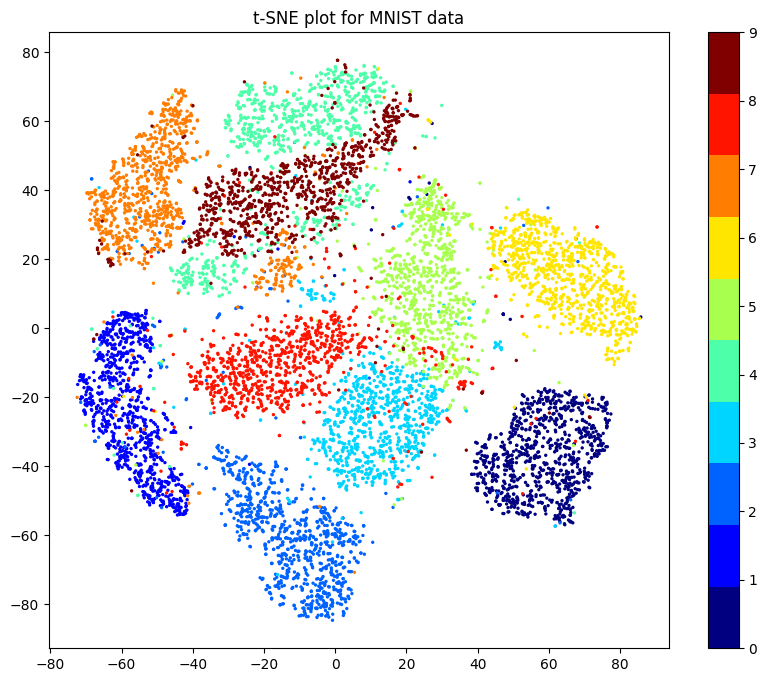

In [448]:
x_sample = np.array(x_train_reduced).reshape(-1, 28*28)
y_sample =  [y_train_reduced[i] for i in range(len(x_sample))]

# Führen Sie t-SNE durch
tsne = TSNE(n_components=2, random_state=0)
x_2d = tsne.fit_transform(x_sample)

# Erstelle den Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('jet', 10)
sc = plt.scatter(x_2d[:, 0], x_2d[:, 1], s=2, c=y_sample, cmap=cmap)
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE plot for MNIST data')
plt.show()

# Ähnlichkeitsmatrix

In [449]:
# Berechnen der Embeddings für den reduzierten Datensatz
embeddings = encoder.predict(x_train_reduced)

similarity_matrix = squareform(pdist(embeddings, 'euclidean'))
 
print(similarity_matrix[:10][:10])  # Zeigt die ersten 10x10 Elemente


313/313 [==============================] - 1s 2ms/step
[[ 0.          8.72775029  8.34832914 ... 17.71886823 17.74454835
  19.08862329]
 [ 8.72775029  0.          9.46540079 ... 21.01164682 20.50621863
  22.14490748]
 [ 8.34832914  9.46540079  0.         ... 17.12049941 16.9354434
  18.35285659]
 ...
 [ 6.02461473  9.34212491  9.34644357 ... 18.04776176 17.54881138
  19.3248838 ]
 [ 5.0584625  10.06456098 10.09421338 ... 18.92869195 19.10459856
  20.33486704]
 [14.79396578 13.30594954 11.94922791 ... 19.83443613 19.66019035
  20.12400768]]


# Nächste-Nachbarn-Methode

In [450]:
# distances are the calculated distances of the data points
distances = similarity_matrix

# here you can set the threshold value n_neighbours
n_neighbours = 200

# sort the scores and take the first n_neighbours values
sorted_distances = [sorted(distance_array)[:n_neighbours] for distance_array in distances]

# calculate the average for each array
averages = [sum(score_array) / n_neighbours for score_array in sorted_distances]

# normalization and transformation
min_score = min(averages)
max_score = max(averages)
rarity_score = [(average - min_score) / (max_score - min_score) for average in averages]


In [451]:
rarity_score = np.array(rarity_score)

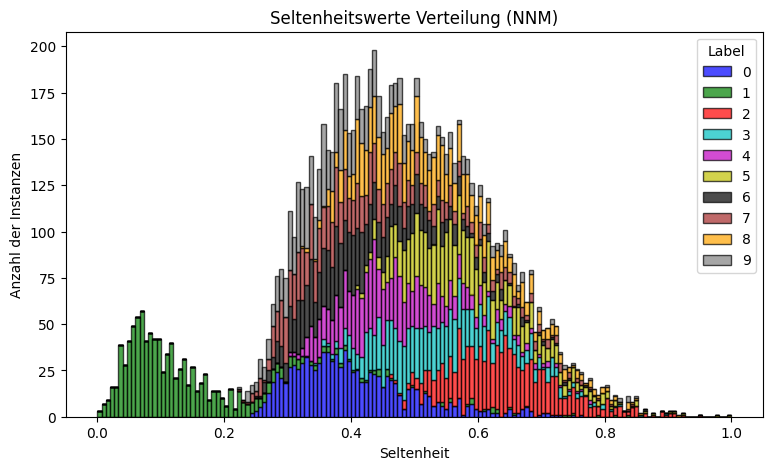

In [577]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 5))
plt.title('Seltenheitswerte Verteilung (NNM)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(y_train_reduced, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

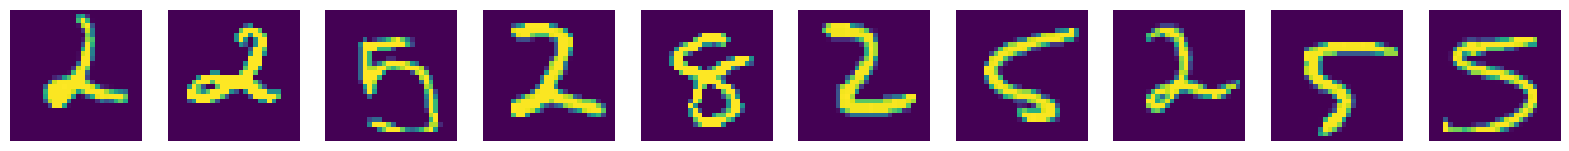

In [453]:
plt.figure(figsize=(20, 8))

indices_of_rarest = np.argsort(rarity_score)[-10:]

# Zeige die Top 5 Ziffern mit der größten Ähnlichkeit zu anderen
for j, i in enumerate(indices_of_rarest, 1):
    plt.subplot(2, 10, j)
    gen_image(x_train_reduced[[i]])
    plt.axis('off')


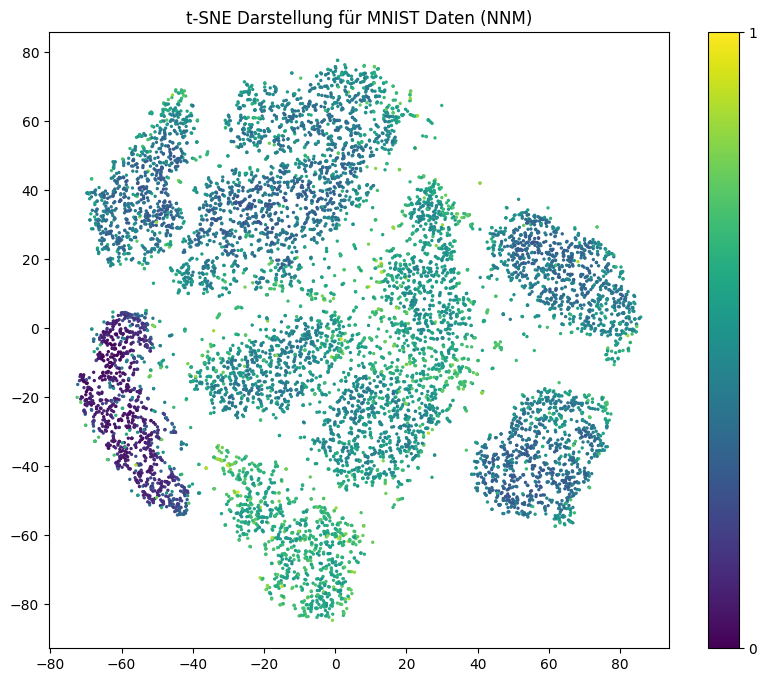

In [560]:
# Erstelle den Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(x_2d[:, 0], x_2d[:, 1], s=2, c=rarity_score, cmap='viridis')
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für MNIST Daten (NNM)')
plt.show()

# Flow Methode

In [455]:
distances_normalized = (distances - distances.min()) / (distances.max() - distances.min())

In [456]:
# compute flows based on distance with a decay parameter
def compute_flows(distance, decay=10):
    return np.exp(-decay * distance)

# sort the scores to get their sorted indices
sorted_ids = np.argsort(distances_normalized)

# here you can set the threshold value n_next_hubs
n_next_hubs = 200

# iterative flow search
inward_flow_results = np.zeros(len(distances_normalized))
for id in tqdm(range(len(distances_normalized))):
    idx = sorted_ids[id][1:(n_next_hubs + 1)]
    inward_flow_results[id] += compute_flows(distances_normalized[id, idx]).sum()

# normalization and transformation
rarity_score_flow = 1 / inward_flow_results
min_score = min(rarity_score_flow)
max_score = max(rarity_score_flow)
rarity_score_flow = (rarity_score_flow - min_score) / (max_score - min_score)

100%|██████████| 10000/10000 [00:00<00:00, 54319.46it/s]


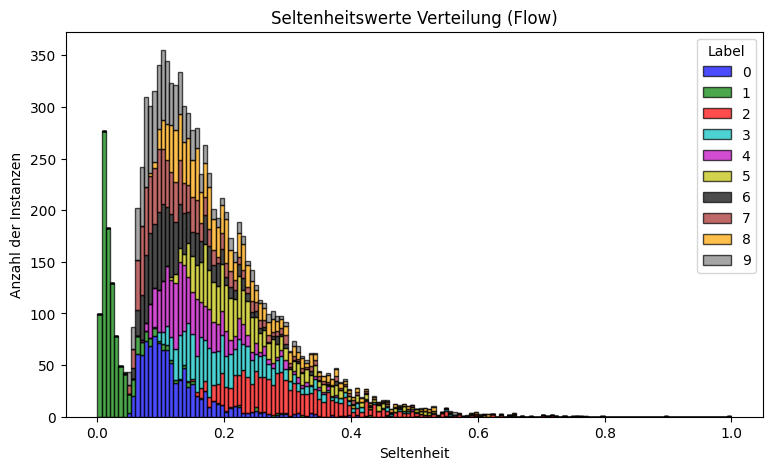

In [576]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 5))
plt.title('Seltenheitswerte Verteilung (Flow)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(y_train_reduced, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score_flow[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

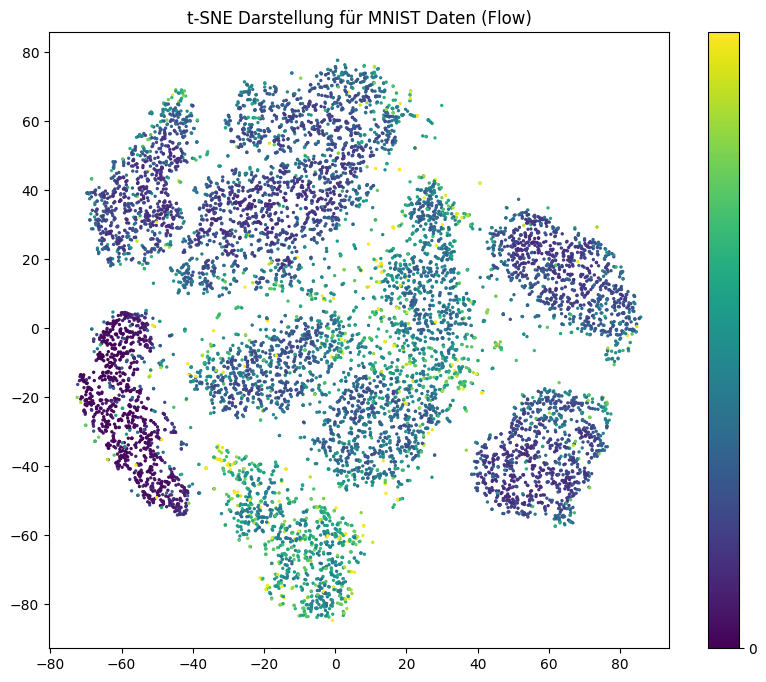

In [561]:
# Erstelle den Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(x_2d[:, 0], x_2d[:, 1], s=2, vmax=0.5 , c=rarity_score_flow, cmap='viridis')
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für MNIST Daten (Flow)')
plt.show()

# Ausreißer Methoden

### LOF

In [459]:
from pyod.models.lof import LOF

# LOF-Modell mit 200 Nachbarn instanziieren
lof = LOF(n_neighbors=200, novelty=True, metric='cosine')

# LOF an der Ähnlichkeitsmatrix anpassen
lof.fit(similarity_matrix)

# Anomalie-Scores berechnen
rarity_score_lof = lof.decision_function(similarity_matrix)

# Normalisierung der Scores
min_score = min(rarity_score_lof)
max_score = max(rarity_score_lof)
rarity_score_lof = (rarity_score_lof - min_score) / (max_score - min_score)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


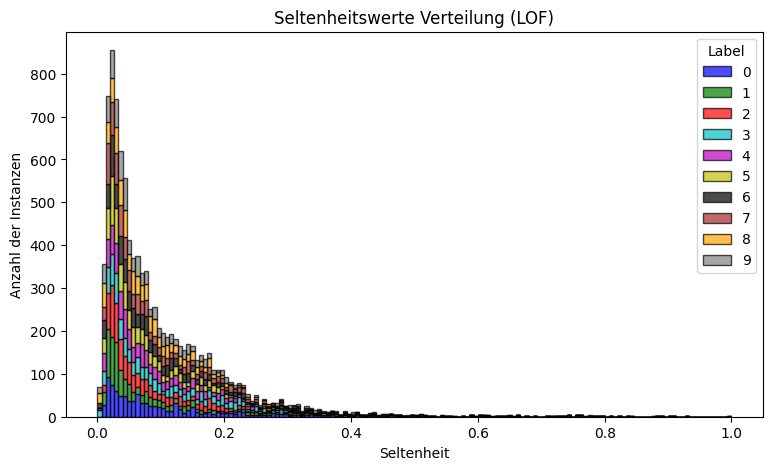

In [575]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 5))
plt.title('Seltenheitswerte Verteilung (LOF)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(y_train_reduced, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score_lof[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

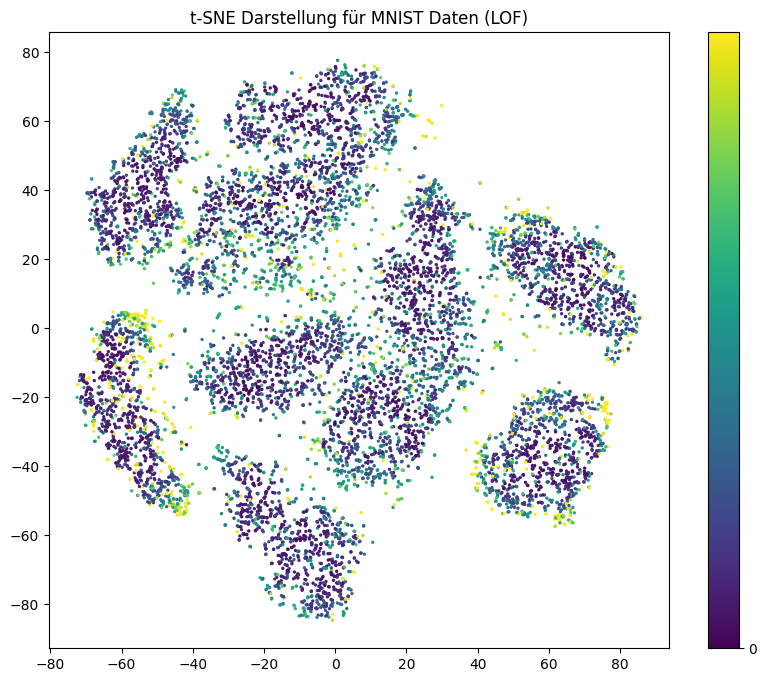

In [565]:
# Erstelle den Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(x_2d[:, 0], x_2d[:, 1], s=2 ,vmax=0.3, c=rarity_score_lof, cmap='viridis')
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für MNIST Daten (LOF)')
plt.show()

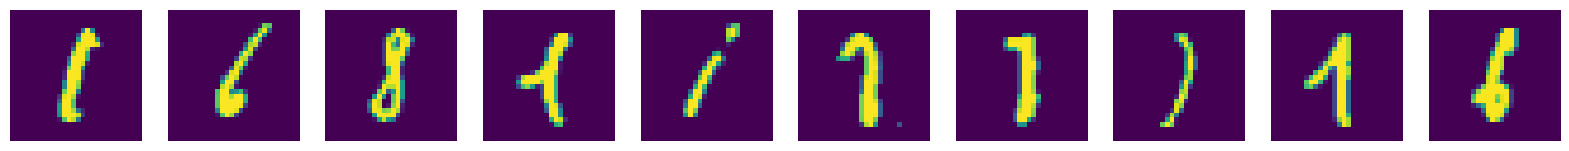

In [462]:
plt.figure(figsize=(20, 8))

indices_of_rarest = np.argsort(rarity_score_lof)[-10:]

# Zeige die Top 5 Ziffern mit der größten Ähnlichkeit zu anderen
for j, i in enumerate(indices_of_rarest, 1):
    plt.subplot(2, 10, j)
    gen_image(x_train_reduced[[i]])
    plt.axis('off')


### k-nn (langsam)

In [232]:
from pyod.models.knn import KNN

# KNN-Modell mit 20 Nachbarn instanziieren
knn = KNN(n_neighbors=200, contamination=0.1, metric='euclidean')

# KNN an der Ähnlichkeitsmatrix anpassen
knn.fit(similarity_matrix)

# Anomalie-Scores berechnen
outlier_scores_knn = knn.decision_function(similarity_matrix)

# Normalisierung der Scores
min_score = min(outlier_scores_knn)
max_score = max(outlier_scores_knn)
rarity_score_knn = (outlier_scores_knn - min_score) / (max_score - min_score)


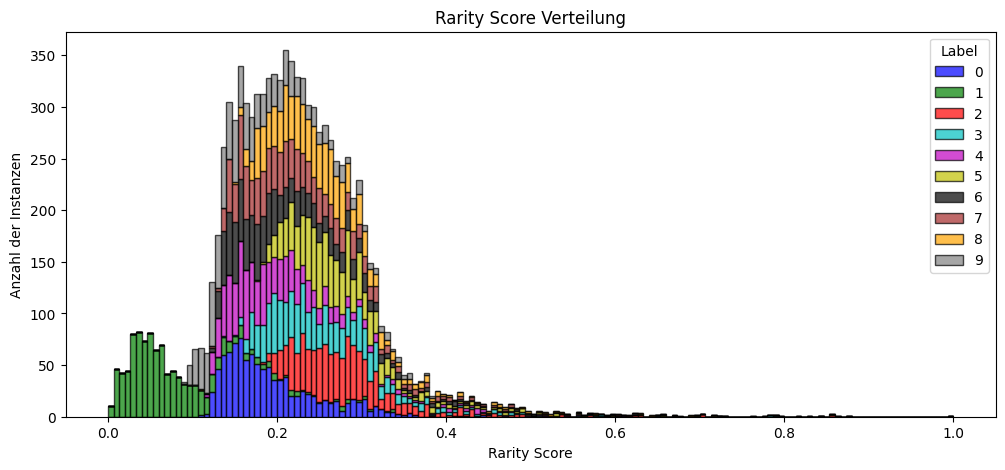

In [233]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(12, 5))
plt.title('Rarity Score Verteilung')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(y_train_reduced, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score_knn[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])
plt.xlabel('Rarity Score')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

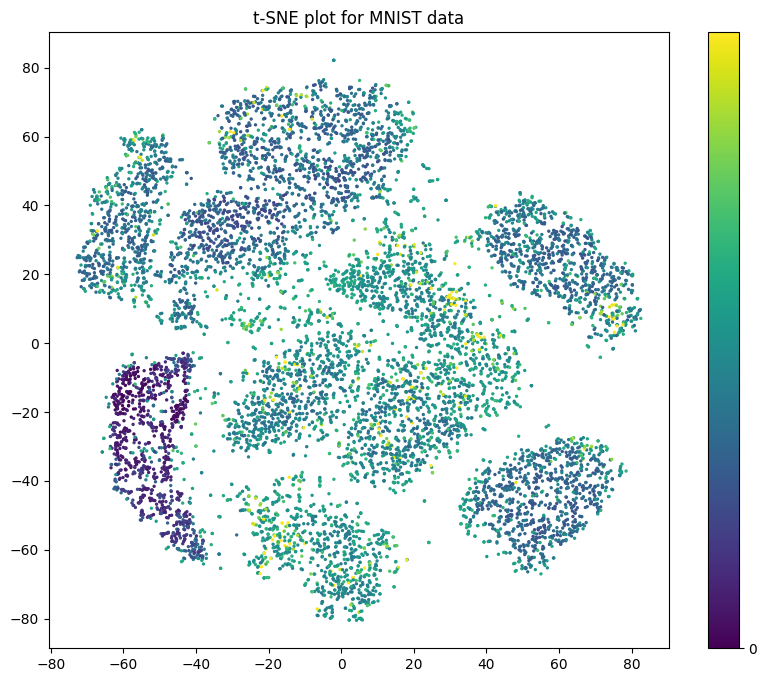

In [239]:
# Erstelle den Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(x_2d[:, 0], x_2d[:, 1], s=2 ,vmax=0.5, c=rarity_score_knn, cmap='viridis')
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für MNIST Daten (NNM)')
plt.show()

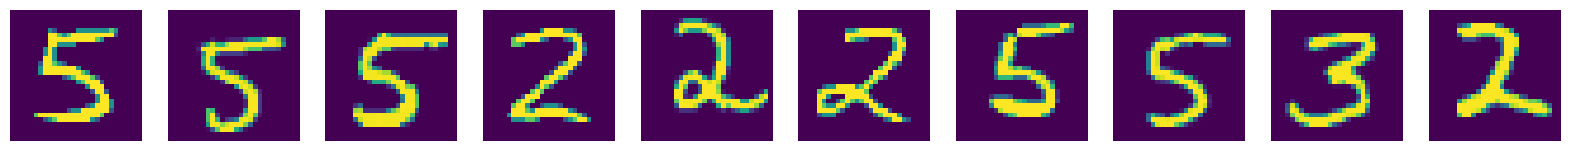

In [240]:
plt.figure(figsize=(20, 8))

indices_of_rarest = np.argsort(rarity_score_knn)[-10:]

# Zeige die Top 5 Ziffern mit der größten Ähnlichkeit zu anderen
for j, i in enumerate(indices_of_rarest, 1):
    plt.subplot(2, 10, j)
    gen_image(x_train_reduced[[i]])
    plt.axis('off')


### SOS

In [467]:
from pyod.models.sos import SOS

# SOS-Modell mit Standardparametern instanziieren
sos = SOS(metric='euclidean', perplexity=200)

# SOS an der Ähnlichkeitsmatrix anpassen
sos.fit(similarity_matrix)

# Anomalie-Scores berechnen
outlier_scores_sos = sos.decision_function(similarity_matrix)

# Normalisierung der Scores
min_score = min(outlier_scores_sos)
max_score = max(outlier_scores_sos)
rarity_score_sos = (outlier_scores_sos - min_score) / (max_score - min_score)


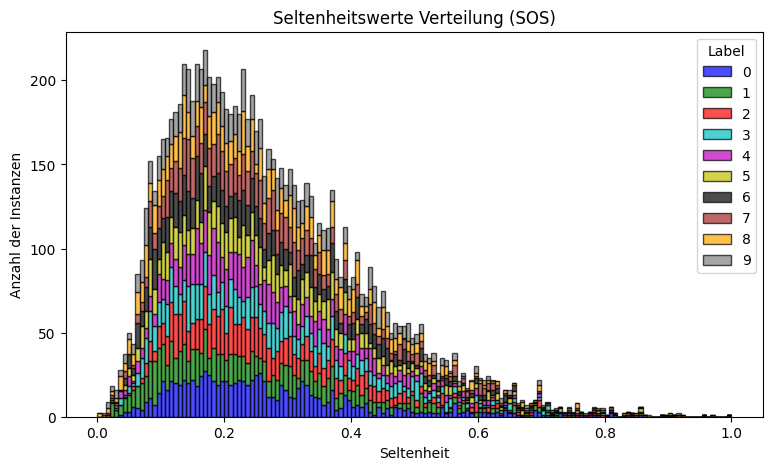

In [571]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 5))
plt.title('Seltenheitswerte Verteilung (SOS)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(y_train_reduced, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score_sos[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])
plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

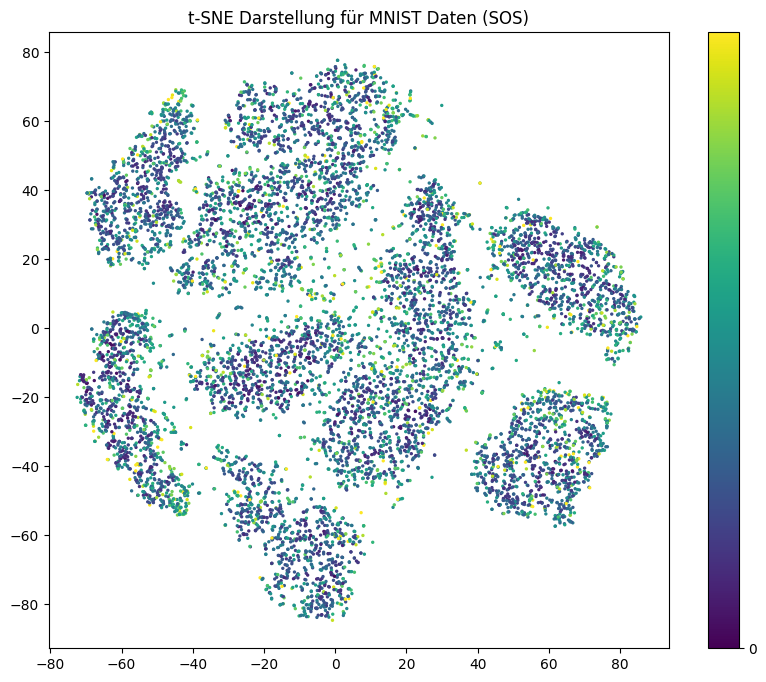

In [567]:
# Erstelle den Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(x_2d[:, 0], x_2d[:, 1], s=2 ,vmax=0.7, c=rarity_score_sos, cmap='viridis')
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für MNIST Daten (SOS)')
plt.show()

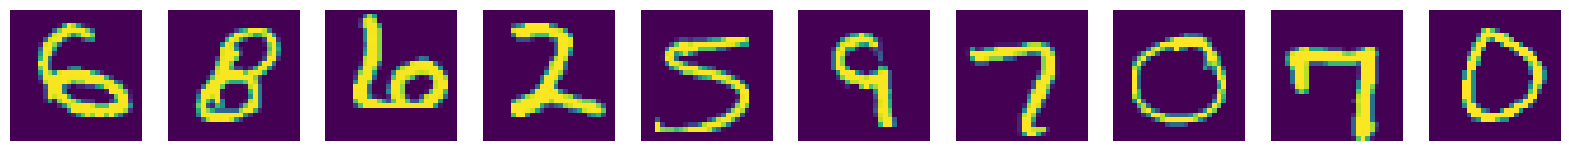

In [470]:
plt.figure(figsize=(20, 8))

indices_of_rarest = np.argsort(rarity_score_sos)[-10:]

# Zeige die Top 5 Ziffern mit der größten Ähnlichkeit zu anderen
for j, i in enumerate(indices_of_rarest, 1):
    plt.subplot(2, 10, j)
    gen_image(x_train_reduced[[i]])
    plt.axis('off')


# Test 1: Reduziere die Ziffer 0 auf 50 Instanzen.

In [509]:
# Definiere die Anzahl der gewünschten Beispiele pro Ziffer
examples_per_digit = {
    0: 50
}

# Initialisiere eine leere Liste, um die ausgewählten Indizes zu speichern
selected_indices = []

# Wandele die Labels von One-Hot-Encoding in Ziffern um
y_train_digits = y_train_reduced

# Iteriere über die einzigartigen Labels im Trainingsdatensatz
for label in np.unique(y_train_digits):
    if label in examples_per_digit:
        if label == 0:
            # Für Ziffer 0, verwende die ersten 50 Beispiele
            idx = np.where((y_train_digits == label) & (label == 0))[0][:examples_per_digit[label]]
            selected_indices.extend(idx)
        else:
            # Für andere Ziffern, füge alle Beispiele hinzu, ohne Reduzierung
            idx = np.where(y_train_digits == label)[0]
            selected_indices.extend(idx)
    else:
        # Für Ziffern, die nicht in examples_per_digit definiert sind, füge alle Beispiele hinzu
        idx = np.where(y_train_digits == label)[0]
        selected_indices.extend(idx)

# Konvertiere die ausgewählten Indizes in ein Numpy-Array
selected_indices = np.array(selected_indices)

x_red_array = np.array(x_train_reduced)
y_red_array = np.array(y_train_reduced)

# Erstelle die reduzierten Datensätze
x_reduced_zero = x_red_array[selected_indices]
y_reduced_zero = y_red_array[selected_indices]


In [526]:
matching_indices = []
for element in x_reduced_zero:
    # Hier prüfen wir jedes Element in x_train_reduced
    for idx, train_element in enumerate(x_train_reduced):
        if np.array_equal(element, train_element):  # Vergleicht die gesamten Arrays
            matching_indices.append(idx)
            break  # Unterbrechen, wenn eine Übereinstimmung gefunden wurde

# Reduzieren der similarity_matrix auf die entsprechenden Zeilen und Spalten
filtered_similarity_matrix = similarity_matrix[np.ix_(matching_indices, matching_indices)]


In [544]:
# distances are the calculated distances of the data points
distances = filtered_similarity_matrix

# here you can set the threshold value n_neighbours
n_neighbours = 200

# sort the scores and take the first n_neighbours values
sorted_distances = [sorted(distance_array)[:n_neighbours] for distance_array in distances]

# calculate the average for each array
averages = [sum(score_array) / n_neighbours for score_array in sorted_distances]

# normalization and transformation
min_score = min(averages)
max_score = max(averages)
rarity_score_reduced_zero = [(average - min_score) / (max_score - min_score) for average in averages]


In [545]:
distances_normalized = (distances - distances.min()) / (distances.max() - distances.min())

In [546]:
# compute flows based on distance with a decay parameter
def compute_flows(distance, decay=10):
    return np.exp(-decay * distance)

# sort the scores to get their sorted indices
sorted_ids = np.argsort(distances_normalized)

# here you can set the threshold value n_next_hubs
n_next_hubs = 200

# iterative flow search
inward_flow_results = np.zeros(len(distances_normalized))
for id in tqdm(range(len(distances_normalized))):
    idx = sorted_ids[id][1:(n_next_hubs + 1)]
    inward_flow_results[id] += compute_flows(distances_normalized[id, idx]).sum()

# normalization and transformation
rarity_score_reduced_zero_flow = 1 / inward_flow_results
min_score = min(rarity_score_reduced_zero_flow)
max_score = max(rarity_score_reduced_zero_flow)
rarity_score_reduced_zero_flow = (rarity_score_reduced_zero_flow - min_score) / (max_score - min_score)

100%|██████████| 4550/4550 [00:00<00:00, 150035.64it/s]


### Test

In [547]:
rarity_score_reduced_zero = np.array(rarity_score_reduced_zero)
rarity_score_reduced_zero_flow = np.array(rarity_score_reduced_zero_flow)

Mittelwerte : 0.31074322146505984 0.5635176744530137 0.056971854802628404 0.18046477799105556


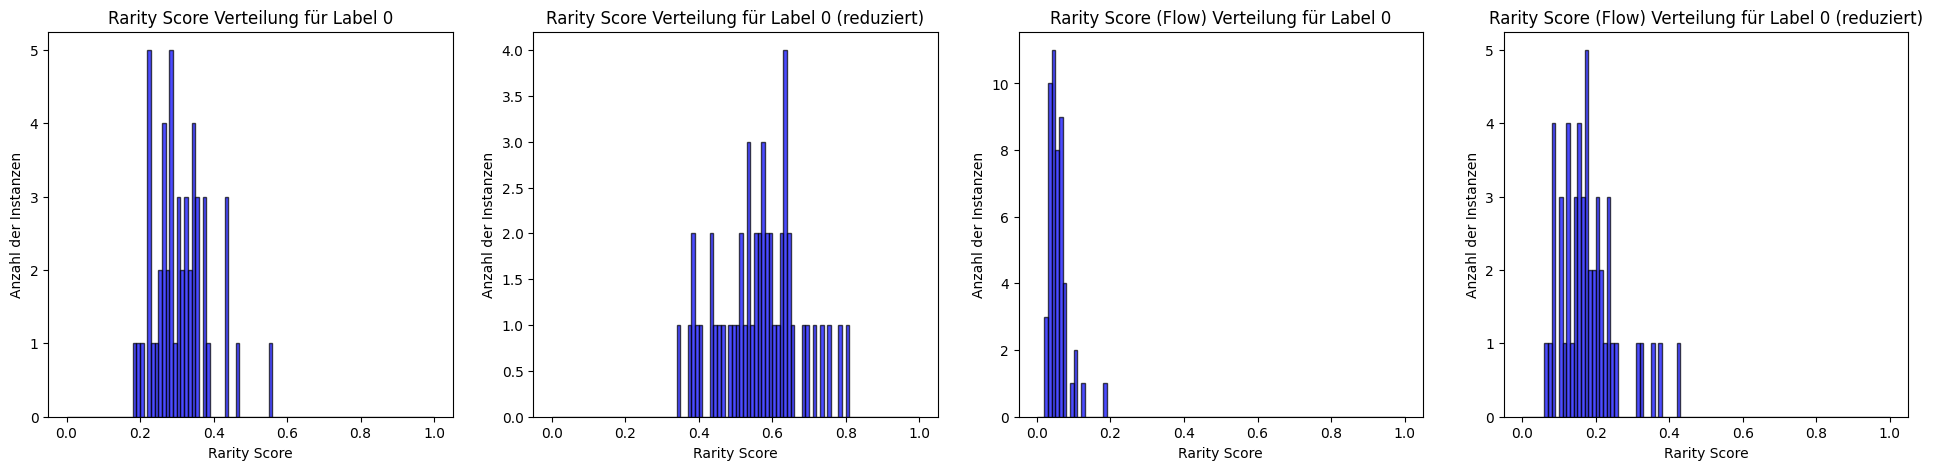

In [550]:
# Labels definieren
labels_reduced = y_reduced_zero
labels = y_train_reduced

# Filtern der Daten für Label 0
filtered_ind = np.where(labels==0)[0]
filtered_rarityScore = rarity_score[filtered_ind[:50]]
filtered_rarityScore_red = rarity_score_reduced_zero[(labels_reduced == 0)]
filtered_rarityScore_flow = rarity_score_flow[filtered_ind[:50]]
filtered_rarityScore_red_flow = rarity_score_reduced_zero_flow[(labels_reduced == 0)]

# Erstellen der 4 Histogramme in einer Reihe
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
print('Mittelwerte :', filtered_rarityScore.mean(), filtered_rarityScore_red.mean(), filtered_rarityScore_flow.mean(),filtered_rarityScore_red_flow.mean())

# Histogramm für normale Rarity Scores
axs[0].hist(filtered_rarityScore, range=[0, 1], bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_title('Rarity Score Verteilung für Label 0')
axs[0].set_xlabel('Rarity Score')
axs[0].set_ylabel('Anzahl der Instanzen')

# Histogramm für reduzierte Rarity Scores
axs[1].hist(filtered_rarityScore_red, range=[0, 1], bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[1].set_title('Rarity Score Verteilung für Label 0 (reduziert)')
axs[1].set_xlabel('Rarity Score')
axs[1].set_ylabel('Anzahl der Instanzen')

# Histogramm für Flow Rarity Scores
axs[2].hist(filtered_rarityScore_flow, range=[0, 1], bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[2].set_title('Rarity Score (Flow) Verteilung für Label 0')
axs[2].set_xlabel('Rarity Score')
axs[2].set_ylabel('Anzahl der Instanzen')

# Histogramm für reduzierte Flow Rarity Scores
axs[3].hist(filtered_rarityScore_red_flow, range=[0, 1], bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[3].set_title('Rarity Score (Flow) Verteilung für Label 0 (reduziert)')
axs[3].set_xlabel('Rarity Score')
axs[3].set_ylabel('Anzahl der Instanzen')

plt.show()

# Multi Test 1: Reduziere Ziffer '0' 

In [471]:
# Definiere die Anzahl der gewünschten Beispiele pro Ziffer
examples_per_digit = [700, 500, 250, 100, 50, 10]

# Initialisiere eine leere Liste, um die ausgewählten Indizes zu speichern
selected_indices_list = []

# Wandele die Labels von One-Hot-Encoding in Ziffern um
y_train_digits = y_train_reduced

# Iteriere über die gewünschten Beispiele pro Ziffer
for n in examples_per_digit:
    selected_indices = []
    for label in np.unique(y_train_digits):
        if label == 0:
            # Für Ziffer 0, verwende die ersten n Beispiele
            idx = np.where((y_train_digits == label) & (label == 0))[0][:n]
            selected_indices.extend(idx)
        else:
            # Für andere Ziffern, füge alle Beispiele hinzu, ohne Reduzierung
            idx = np.where(y_train_digits == label)[0]
            selected_indices.extend(idx)
    selected_indices_list.append(selected_indices)

x_red_array = np.array(x_train_reduced)
y_red_array = np.array(y_train_reduced)

# Erstelle die reduzierten Datensätze
x_reduced_list_zero = [x_red_array[idx] for idx in selected_indices_list]
y_reduced_list_zero = [y_red_array[idx] for idx in selected_indices_list]

In [472]:
# Initialisiere Listen für die Seltenheitswerte
rarity_scores_reduced_zero = []
rarity_scores_reduced_zero_flow = []
rarity_scores_lof_zero = []  # Für LOF hinzugefügt
rarity_scores_sp_zero = []   # Für SP hinzugefügt
rarity_scores_sos_zero = []  # Für SOS hinzugefügt

# Für jedes x_reduced Array
for x_reduced in x_reduced_list_zero:
    matching_indices = []
    for element in x_reduced:
        # Hier prüfen wir jedes Element in x_train_reduced
        for idx, train_element in enumerate(x_train_reduced):
            if np.array_equal(element, train_element):  # Vergleicht die gesamten Arrays
                matching_indices.append(idx)
                break  # Unterbrechen, wenn eine Übereinstimmung gefunden wurde

    # Reduzieren der similarity_matrix auf die entsprechenden Zeilen und Spalten
    filtered_similarity_matrix = similarity_matrix[np.ix_(matching_indices, matching_indices)]

    # distances are the calculated distances of the data points
    distances = filtered_similarity_matrix

    # here you can set the threshold value n_neighbours
    n_neighbours = 200

    # sort the scores and take the first n_neighbours values
    sorted_distances = [sorted(distance_array)[:n_neighbours] for distance_array in distances]

    # calculate the average for each array
    averages = [sum(score_array) / n_neighbours for score_array in sorted_distances]

    # normalization and transformation
    min_score = min(averages)
    max_score = max(averages)
    rarity_score_reduced_zero = [(average - min_score) / (max_score - min_score) for average in averages]

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_reduced_zero.append(rarity_score_reduced_zero)

    # Normaliserung für Flow
    distances_normalized = (distances - distances.min()) / (distances.max() - distances.min())

    # sort the scores to get their sorted indices
    sorted_ids = np.argsort(distances_normalized)

    # here you can set the threshold value n_next_hubs
    n_next_hubs = 200

    # iterative flow search
    inward_flow_results = np.zeros(len(distances_normalized))
    for id in tqdm(range(len(distances_normalized))):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += compute_flows(distances_normalized[id, idx]).sum()

    # normalization and transformation
    rarity_score_reduced_zero_flow = 1 / inward_flow_results
    min_score = min(rarity_score_reduced_zero_flow)
    max_score = max(rarity_score_reduced_zero_flow)
    rarity_score_reduced_zero_flow = (rarity_score_reduced_zero_flow - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_reduced_zero_flow.append(rarity_score_reduced_zero_flow)

    # LOF-Modell mit 200 Nachbarn instanziieren und anpassen
    lof = LOF(n_neighbors=200, novelty=True, metric='cosine')
    lof.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    rarity_score_lof_zero = lof.decision_function(distances)
    min_score = min(rarity_score_lof_zero)
    max_score = max(rarity_score_lof_zero)
    rarity_score_lof_zero = (rarity_score_lof_zero - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_lof_zero.append(rarity_score_lof_zero)

    # SP-Modell mit 200 Samples instanziieren und anpassen
    sp = Sampling(subset_size=200, contamination=0.1, metric='euclidean')
    sp.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    outlier_scores_sp_zero = sp.decision_function(distances)
    min_score = min(outlier_scores_sp_zero)
    max_score = max(outlier_scores_sp_zero)
    rarity_score_sp_zero = (outlier_scores_sp_zero - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_sp_zero.append(rarity_score_sp_zero)

    # SOS-Modell instanziieren und anpassen
    sos = SOS(metric='euclidean', perplexity=200)
    sos.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    outlier_scores_sos_zero = sos.decision_function(distances)
    min_score = min(outlier_scores_sos_zero)
    max_score = max(outlier_scores_sos_zero)
    rarity_score_sos_zero = (outlier_scores_sos_zero - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_sos_zero.append(rarity_score_sos_zero)

100%|██████████| 9700/9700 [00:00<00:00, 185235.47it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
100%|██████████| 9500/9500 [00:00<00:00, 182921.11it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
100%|██████████| 9250/9250 [00:00<00:00, 195016.25it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: in

In [473]:
for i, scores in enumerate(rarity_scores_reduced_zero):
    rarity_scores_reduced_zero[i] = np.array(rarity_scores_reduced_zero[i])
    rarity_scores_reduced_zero_flow[i] = np.array(rarity_scores_reduced_zero_flow[i])
    rarity_scores_lof_zero[i] = np.array(rarity_scores_lof_zero[i])
    rarity_scores_sos_zero[i] = np.array(rarity_scores_sos_zero[i])
    rarity_scores_sp_zero[i] = np.array(rarity_scores_sp_zero[i])

In [595]:
rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []

# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced_zero, rarity_scores_reduced_zero_flow, rarity_scores_lof_zero, rarity_scores_sos_zero, rarity_scores_sp_zero)):
    # Filtern der Daten für Label 0
    filtered_ind = np.where(y_train_reduced == 0)[0]
    filtered_rarity_score = rarity_score[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red = scores[y_reduced_list_zero[i]== 0]

    filtered_rarity_score_flow = rarity_score_flow[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_flow = scores_flow[y_reduced_list_zero[i] == 0]
    
    filtered_rarity_score_lof = rarity_score_lof[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_lof = scores_lof[y_reduced_list_zero[i] == 0]
        
    filtered_rarity_score_sos = rarity_score_sos[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_sos = scores_sos[y_reduced_list_zero[i] == 0]

    filtered_rarity_score_sp = rarity_score_sp[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_sp = scores_sp[y_reduced_list_zero[i] == 0]

    # Berechne Mittelwert
    rarity_scores_means.append(filtered_rarity_score.mean())
    rarity_scores_red_means.append(filtered_rarity_score_red.mean())

    rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
    rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

    rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
    rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

    rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
    rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

    rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
    rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)


[0.4059302622831383, 0.4062862593641399, 0.40813469489492565, 0.3923522335491332, 0.3877561301637303, 0.3879142321178787] 
  [0.4466319812399198, 0.4916180365549906, 0.6151023271574623, 0.7541176477432394, 0.7536986553642961, 0.8385440775349873] 
  [0.12432753972688573, 0.12454696720193438, 0.12668838176700498, 0.11624861150526801, 0.11398173040332091, 0.11138477347317602] 
  [0.14570297853463382, 0.17185083503518342, 0.2564381008894278, 0.3996363976010666, 0.4087338005263474, 0.6080497951628928] 
  [0.11270217809528235, 0.1133630557387022, 0.11813377664299307, 0.09109881933122325, 0.0910192128656515, 0.10222463635518164] 
  [0.12113954656816942, 0.11244908108799151, 0.05591756949699612, 0.20289454118219233, 0.2962652919980759, 0.3311467183451893] 
  [0.27219808546311713, 0.2747318702937666, 0.2734481095959941, 0.2605732302955599, 0.23365046211303592, 0.21792346185071626] 
  [0.27618663659642345, 0.28337497873435125, 0.3092055955832935, 0.3719227846210618, 0.42751493041921085, 0.568628

(0.06683086408390561, 0.6262912890177796)

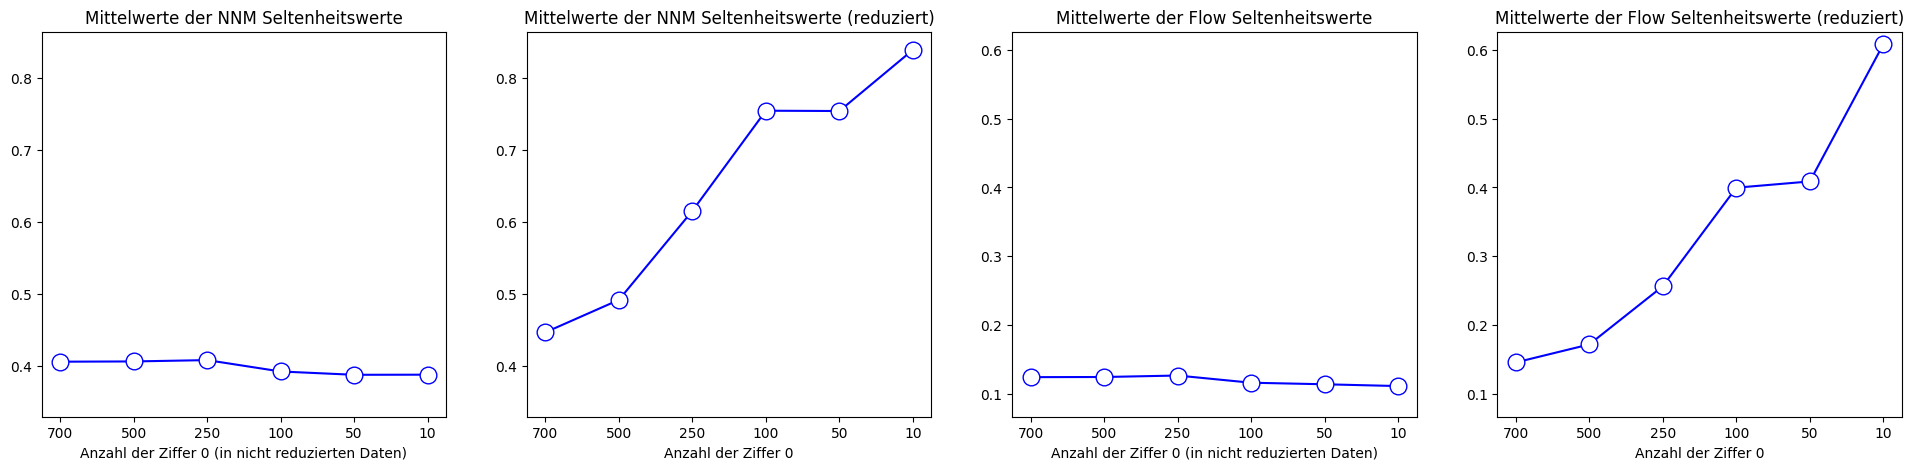

In [596]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.85, max(rarity_scores_red_means)*1.03])

axs[1].plot(rarity_scores_red_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Anzahl der Ziffer 0')
axs[1].set_ylim([min(rarity_scores_means)*0.85, max(rarity_scores_red_means)*1.03])

axs[2].plot(rarity_scores_flow_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit)))
axs[2].set_xticklabels(examples_per_digit)
axs[2].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.60, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit)))
axs[3].set_xticklabels(examples_per_digit)
axs[3].set_xlabel('Anzahl der Ziffer 0')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.60, max(rarity_scores_red_flow_means)*1.03])

(0.20266881952116614, 0.5856877318019988)

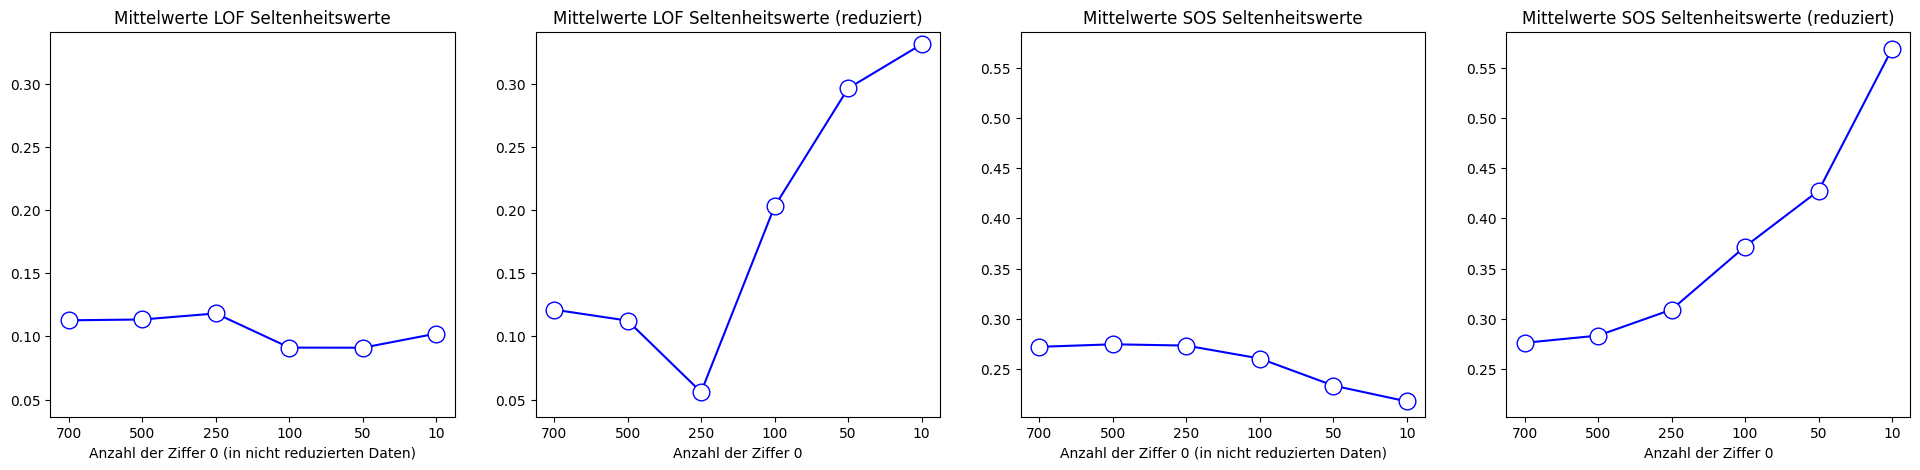

In [592]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_lof_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.4, max(rarity_scores_red_lof_means)*1.03])

axs[1].plot(rarity_scores_red_lof_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Anzahl der Ziffer 0')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.4, max(rarity_scores_red_lof_means)*1.03])

axs[2].plot(rarity_scores_sos_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit)))
axs[2].set_xticklabels(examples_per_digit)
axs[2].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.03])

axs[3].plot(rarity_scores_red_sos_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit)))
axs[3].set_xticklabels(examples_per_digit)
axs[3].set_xlabel('Anzahl der Ziffer 0')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.03])

In [615]:
rarity_scores_lof_zero2 = []  # Für LOF hinzugefügt

# Für jedes x_reduced Array
for x_reduced in x_reduced_list_zero:
    matching_indices = []
    for element in x_reduced:
        # Hier prüfen wir jedes Element in x_train_reduced
        for idx, train_element in enumerate(x_train_reduced):
            if np.array_equal(element, train_element):  # Vergleicht die gesamten Arrays
                matching_indices.append(idx)
                break  # Unterbrechen, wenn eine Übereinstimmung gefunden wurde

    # Reduzieren der similarity_matrix auf die entsprechenden Zeilen und Spalten
    filtered_similarity_matrix = similarity_matrix[np.ix_(matching_indices, matching_indices)]

    # distances are the calculated distances of the data points
    distances = filtered_similarity_matrix

    # here you can set the threshold value n_neighbours
    n_neighbours = 50

    # LOF-Modell mit 50 Nachbarn instanziieren und anpassen
    lof = LOF(n_neighbors=n_neighbours, novelty=True, metric='cosine')
    lof.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    rarity_score_lof_zero2 = lof.decision_function(distances)
    min_score = min(rarity_score_lof_zero2)
    max_score = max(rarity_score_lof_zero2)
    rarity_score_lof_zero2 = (rarity_score_lof_zero2 - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_lof_zero2.append(rarity_score_lof_zero2)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWar

In [616]:
for i, scores in enumerate(rarity_scores_reduced_zero):
    rarity_scores_lof_zero2[i] = np.array(rarity_scores_lof_zero2[i])

In [617]:
rarity_scores_lof2_means = []
rarity_scores_red_lof2_means = []
rarity_scores_means = []
rarity_scores_red_means = []

# Mittelwert Loop
for i, (scores, scores_lof) in enumerate(zip(rarity_scores_reduced_zero, rarity_scores_lof_zero2)):
    # Filtern der Daten für Label 0
    filtered_ind = np.where(y_train_reduced == 0)[0]
    filtered_rarity_score = rarity_score[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red = scores[y_reduced_list_zero[i]== 0]
    
    filtered_rarity_score_lof2 = rarity_score_lof[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_lof2 = scores_lof[y_reduced_list_zero[i] == 0]
        

    # Berechne Mittelwert
    rarity_scores_means.append(filtered_rarity_score.mean())
    rarity_scores_red_means.append(filtered_rarity_score_red.mean())

    rarity_scores_lof2_means.append(filtered_rarity_score_lof2.mean())
    rarity_scores_red_lof2_means.append(filtered_rarity_score_red_lof2.mean())


print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_lof2_means , '\n ', rarity_scores_red_lof2_means)


[0.4059302622831383, 0.4062862593641399, 0.40813469489492565, 0.3923522335491332, 0.3877561301637303, 0.3879142321178787] 
  [0.4466319812399198, 0.4916180365549906, 0.6151023271574623, 0.7541176477432394, 0.7536986553642961, 0.8385440775349873] 
  [0.11270217809528235, 0.1133630557387022, 0.11813377664299307, 0.09109881933122325, 0.0910192128656515, 0.10222463635518164] 
  [0.08830099158362825, 0.08996357304524946, 0.09235059652113267, 0.06913415476844854, 0.03985929076032681, 0.18033678528489155]


Andere Parameter für LOF n_neighbors 

(0.027305763859695447, 0.18574688884343832)

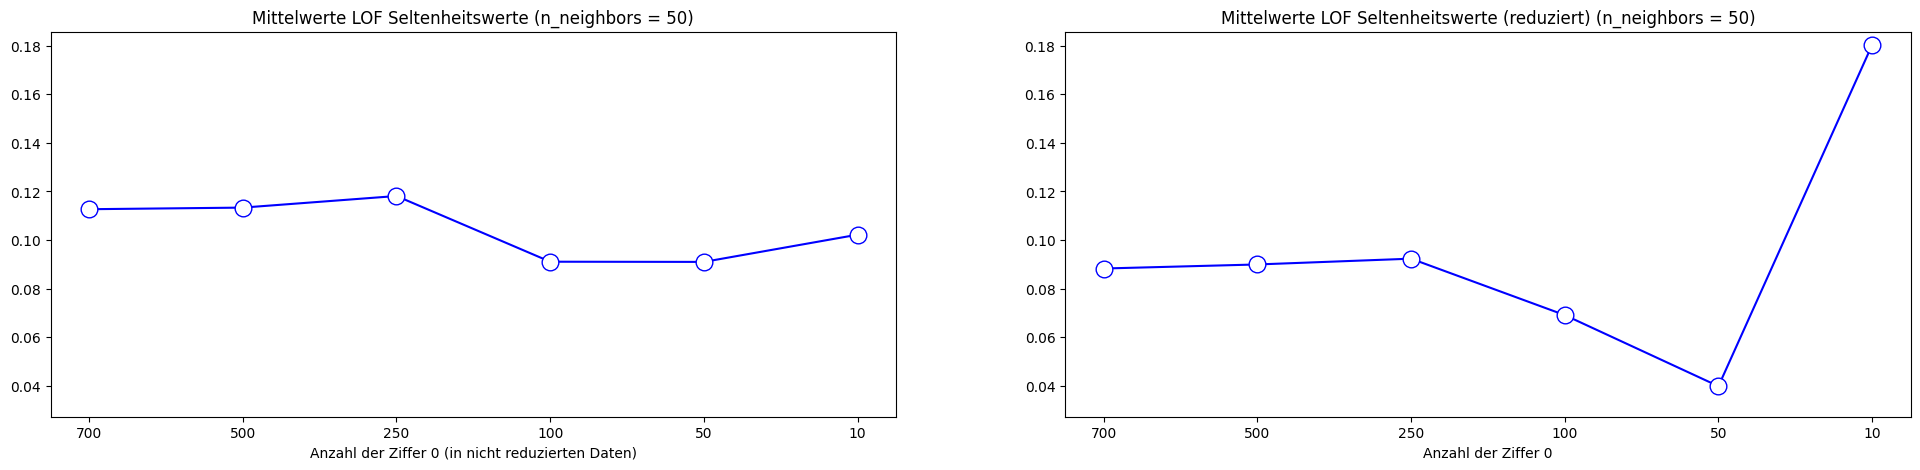

In [621]:
fig, axs = plt.subplots(1, 2, figsize=(24, 5))

axs[0].plot(rarity_scores_lof2_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte (n_neighbors = 50)')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof2_means)*0.3, max(rarity_scores_red_lof2_means)*1.03])

axs[1].plot(rarity_scores_red_lof2_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert) (n_neighbors = 50)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Anzahl der Ziffer 0')
axs[1].set_ylim([min(rarity_scores_lof2_means)*0.3, max(rarity_scores_red_lof2_means)*1.03])

# Multi Test 2: Reduziere Ziffer '1'

In [477]:
# Definiere die Anzahl der gewünschten Beispiele pro Ziffer
examples_per_digit = [700, 500, 250, 100, 50, 10]

# Initialisiere eine leere Liste, um die ausgewählten Indizes zu speichern
selected_indices_list = []

# Wandele die Labels von One-Hot-Encoding in Ziffern um
y_train_digits = y_train_reduced

# Iteriere über die gewünschten Beispiele pro Ziffer
for n in examples_per_digit:
    selected_indices = []
    for label in np.unique(y_train_digits):
        if label == 1:
            # Für Ziffer 1, verwende die ersten n Beispiele
            idx = np.where((y_train_digits == label) & (label == 1))[0][:n]
            selected_indices.extend(idx)
        else:
            # Für andere Ziffern, füge alle Beispiele hinzu, ohne Reduzierung
            idx = np.where(y_train_digits == label)[0]
            selected_indices.extend(idx)
    selected_indices_list.append(selected_indices)

x_red_array = np.array(x_train_reduced)
y_red_array = np.array(y_train_reduced)

# Erstelle die reduzierten Datensätze
x_reduced_list_one = [x_red_array[idx] for idx in selected_indices_list]
y_reduced_list_one = [y_red_array[idx] for idx in selected_indices_list]

In [478]:
# Initialisiere Listen für die Seltenheitswerte
rarity_scores_reduced_one = []
rarity_scores_reduced_one_flow = []
rarity_scores_lof_one = []  # Für LOF hinzugefügt
rarity_scores_sp_one = []   # Für SP hinzugefügt
rarity_scores_sos_one = []  # Für SOS hinzugefügt

# Für jedes x_reduced Array
for x_reduced in x_reduced_list_one:
    matching_indices = []
    for element in x_reduced:
        # Hier prüfen wir jedes Element in x_train_reduced
        for idx, train_element in enumerate(x_train_reduced):
            if np.array_equal(element, train_element):  # Vergleicht die gesamten Arrays
                matching_indices.append(idx)
                break  # Unterbrechen, wenn eine Übereinstimmung gefunden wurde

    # Reduzieren der similarity_matrix auf die entsprechenden Zeilen und Spalten
    filtered_similarity_matrix = similarity_matrix[np.ix_(matching_indices, matching_indices)]

    # distances are the calculated distances of the data points
    distances = filtered_similarity_matrix

    # here you can set the threshold value n_neighbours
    n_neighbours = 200

    # sort the scores and take the first n_neighbours values
    sorted_distances = [sorted(distance_array)[:n_neighbours] for distance_array in distances]

    # calculate the average for each array
    averages = [sum(score_array) / n_neighbours for score_array in sorted_distances]

    # normalization and transformation
    min_score = min(averages)
    max_score = max(averages)
    rarity_score_reduced_one = [(average - min_score) / (max_score - min_score) for average in averages]

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_reduced_one.append(rarity_score_reduced_one)

    # Normaliserung für Flow
    distances_normalized = (distances - distances.min()) / (distances.max() - distances.min())

    # sort the scores to get their sorted indices
    sorted_ids = np.argsort(distances_normalized)

    # here you can set the threshold value n_next_hubs
    n_next_hubs = 200

    # iterative flow search
    inward_flow_results = np.zeros(len(distances_normalized))
    for id in tqdm(range(len(distances_normalized))):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += compute_flows(distances_normalized[id, idx]).sum()

    # normalization and transformation
    rarity_score_reduced_one_flow = 1 / inward_flow_results
    min_score = min(rarity_score_reduced_one_flow)
    max_score = max(rarity_score_reduced_one_flow)
    rarity_score_reduced_one_flow = (rarity_score_reduced_one_flow - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_reduced_one_flow.append(rarity_score_reduced_one_flow)

    # LOF-Modell mit 200 Nachbarn instanziieren und anpassen
    lof = LOF(n_neighbors=200, novelty=True, metric='cosine')
    lof.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    rarity_score_lof_one = lof.decision_function(distances)
    min_score = min(rarity_score_lof_one)
    max_score = max(rarity_score_lof_one)
    rarity_score_lof_one = (rarity_score_lof_one - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_lof_one.append(rarity_score_lof_one)

    # SP-Modell mit 200 Samples instanziieren und anpassen
    sp = Sampling(subset_size=200, contamination=0.1, metric='euclidean')
    sp.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    outlier_scores_sp_one = sp.decision_function(distances)
    min_score = min(outlier_scores_sp_one)
    max_score = max(outlier_scores_sp_one)
    rarity_score_sp_one = (outlier_scores_sp_one - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_sp_one.append(rarity_score_sp_one)

    # SOS-Modell instanziieren und anpassen
    sos = SOS(metric='euclidean', perplexity=200)
    sos.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    outlier_scores_sos_one = sos.decision_function(distances)
    min_score = min(outlier_scores_sos_one)
    max_score = max(outlier_scores_sos_one)
    rarity_score_sos_one = (outlier_scores_sos_one - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_sos_one.append(rarity_score_sos_one)

100%|██████████| 9700/9700 [00:00<00:00, 173369.31it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
100%|██████████| 9500/9500 [00:00<00:00, 193423.82it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
100%|██████████| 9250/9250 [00:00<00:00, 182647.79it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: in

In [479]:
for i, scores in enumerate(rarity_scores_reduced_one):
    rarity_scores_reduced_one[i] = np.array(rarity_scores_reduced_one[i])
    rarity_scores_reduced_one_flow[i] = np.array(rarity_scores_reduced_one_flow[i])
    rarity_scores_lof_one[i] = np.array(rarity_scores_lof_one[i])
    rarity_scores_sos_one[i] = np.array(rarity_scores_sos_one[i])
    rarity_scores_sp_one[i] = np.array(rarity_scores_sp_one[i])

In [597]:
rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []

# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced_one, rarity_scores_reduced_one_flow, rarity_scores_lof_one, rarity_scores_sos_one, rarity_scores_sp_one)):
    # Filtern der Daten für Label 0
    filtered_ind = np.where(y_train_reduced == 1)[0]
    filtered_rarity_score = rarity_score[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red = scores[y_reduced_list_one[i]== 1]

    filtered_rarity_score_flow = rarity_score_flow[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_flow = scores_flow[y_reduced_list_one[i] == 1]
    
    filtered_rarity_score_lof = rarity_score_lof[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_lof = scores_lof[y_reduced_list_one[i] == 1]
        
    filtered_rarity_score_sos = rarity_score_sos[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_sos = scores_sos[y_reduced_list_one[i] == 1]

    filtered_rarity_score_sp = rarity_score_sp[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_sp = scores_sp[y_reduced_list_one[i] == 1]

    # Berechne Mittelwert
    rarity_scores_means.append(filtered_rarity_score.mean())
    rarity_scores_red_means.append(filtered_rarity_score_red.mean())

    rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
    rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

    rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
    rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

    rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
    rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

    rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
    rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)


[0.1356397966064437, 0.13669382899806384, 0.13487206234276305, 0.12257583472948698, 0.1217598799849649, 0.14079107642627184] 
  [0.12788604826761815, 0.12849485160287308, 0.1539986775474021, 0.3852962303782121, 0.5008279984186089, 0.58789983085961] 
  [0.03082475180697681, 0.030984048994230396, 0.030681505638263246, 0.025165352855980826, 0.024035487821803096, 0.02896185464110626] 
  [0.03203445139613476, 0.03493793279417874, 0.04484222347696776, 0.11127947956679834, 0.18487060828058788, 0.3059901720263499] 
  [0.12764237460110264, 0.13360912256409227, 0.13009160592557167, 0.11946708903172625, 0.12889943873279644, 0.16921958746322527] 
  [0.13716330270238333, 0.13430670200231715, 0.06114317847947732, 0.1074949003593014, 0.16000316949445983, 0.20376822976223025] 
  [0.25508155959065604, 0.2536041400630782, 0.25171518629949946, 0.2467769834057661, 0.23980378353930462, 0.2690359731042372] 
  [0.2506310332579311, 0.240546949327959, 0.23335051158350167, 0.24674420420653134, 0.270296443270130

(0.014421292693081856, 0.31516987718714046)

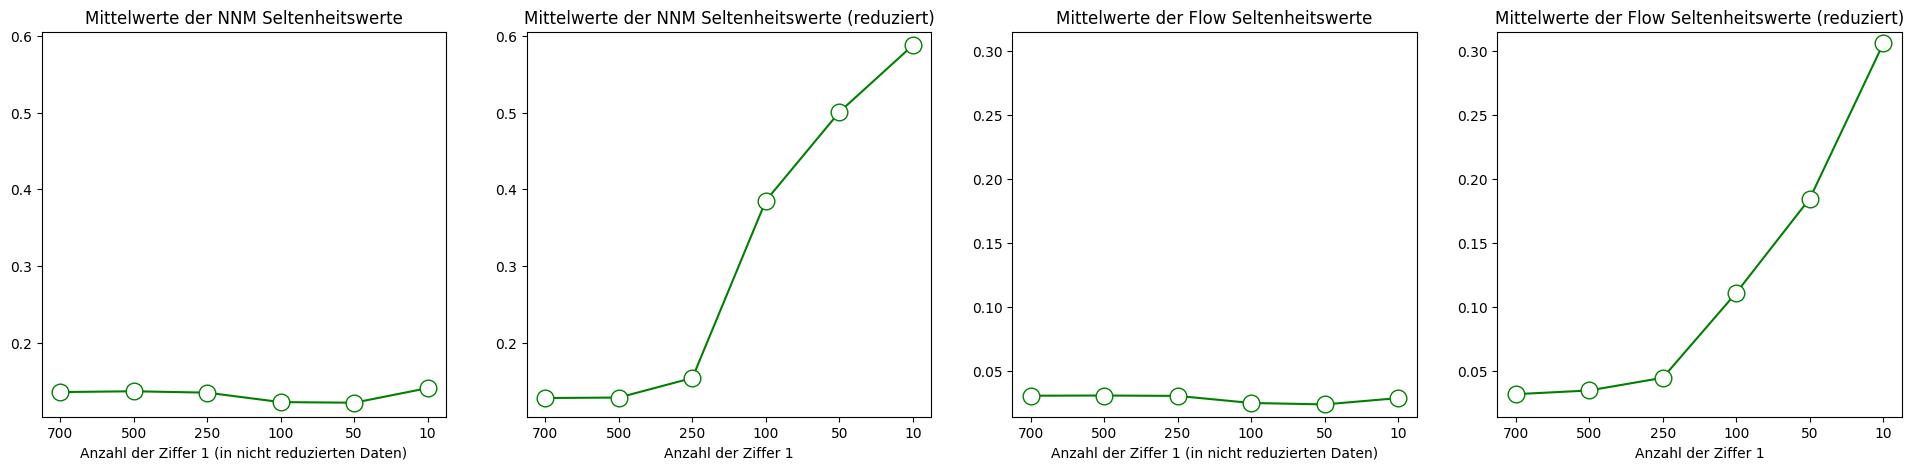

In [598]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='g', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Anzahl der Ziffer 1 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.85, max(rarity_scores_red_means)*1.03])

axs[1].plot(rarity_scores_red_means , color='g', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Anzahl der Ziffer 1')
axs[1].set_ylim([min(rarity_scores_means)*0.85, max(rarity_scores_red_means)*1.03])

axs[2].plot(rarity_scores_flow_means , color='g', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit)))
axs[2].set_xticklabels(examples_per_digit)
axs[2].set_xlabel('Anzahl der Ziffer 1 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.60, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='g', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit)))
axs[3].set_xticklabels(examples_per_digit)
axs[3].set_xlabel('Anzahl der Ziffer 1')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.60, max(rarity_scores_red_flow_means)*1.03])

(0.2230175186915533, 0.3672695697679552)

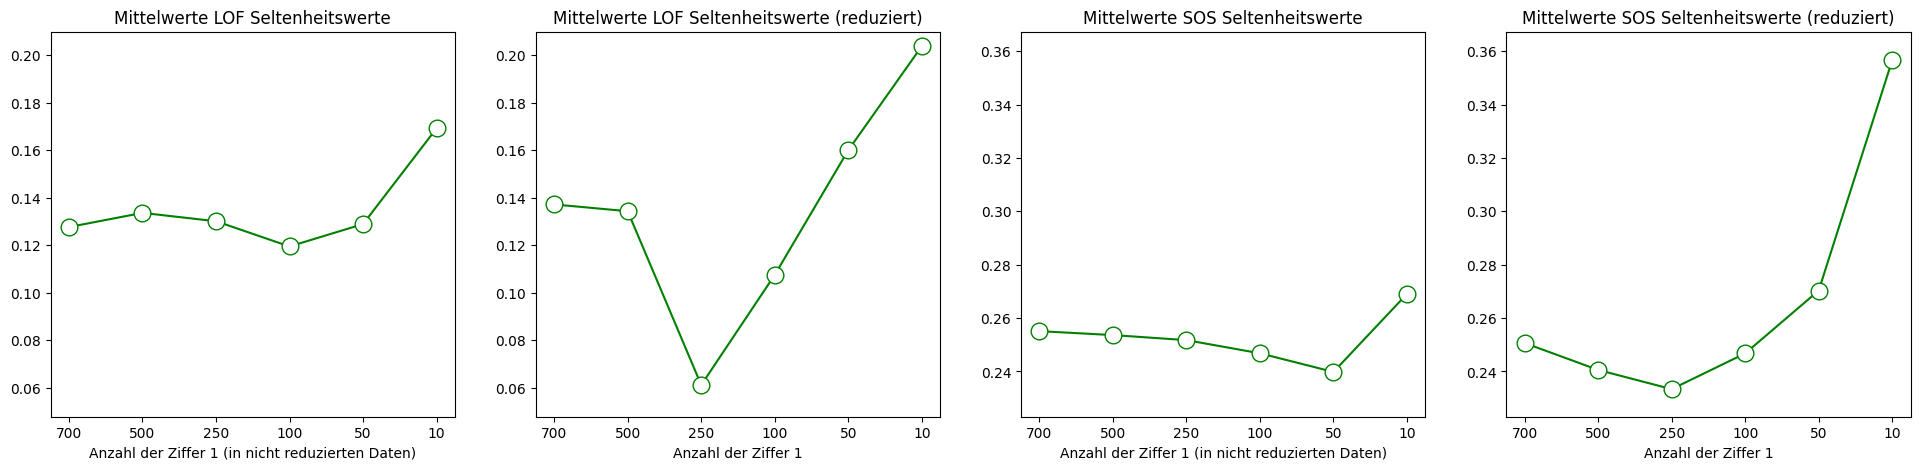

In [599]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_lof_means , color='g', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Anzahl der Ziffer 1 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.4, max(rarity_scores_red_lof_means)*1.03])

axs[1].plot(rarity_scores_red_lof_means , color='g', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Anzahl der Ziffer 1')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.4, max(rarity_scores_red_lof_means)*1.03])

axs[2].plot(rarity_scores_sos_means , color='g', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit)))
axs[2].set_xticklabels(examples_per_digit)
axs[2].set_xlabel('Anzahl der Ziffer 1 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.03])

axs[3].plot(rarity_scores_red_sos_means , color='g', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit)))
axs[3].set_xticklabels(examples_per_digit)
axs[3].set_xlabel('Anzahl der Ziffer 1')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.03])


# Multi Test 3: Reduziere Ziffer '2'

In [485]:
# Definiere die Anzahl der gewünschten Beispiele pro Ziffer
examples_per_digit = [700, 500, 250, 100, 50, 10]

# Initialisiere eine leere Liste, um die ausgewählten Indizes zu speichern
selected_indices_list = []

# Wandele die Labels von One-Hot-Encoding in Ziffern um
y_train_digits = y_train_reduced

# Iteriere über die gewünschten Beispiele pro Ziffer
for n in examples_per_digit:
    selected_indices = []
    for label in np.unique(y_train_digits):
        if label == 2:
            # Für Ziffer 1, verwende die ersten n Beispiele
            idx = np.where((y_train_digits == label) & (label == 2))[0][:n]
            selected_indices.extend(idx)
        else:
            # Für andere Ziffern, füge alle Beispiele hinzu, ohne Reduzierung
            idx = np.where(y_train_digits == label)[0]
            selected_indices.extend(idx)
    selected_indices_list.append(selected_indices)

x_red_array = np.array(x_train_reduced)
y_red_array = np.array(y_train_reduced)

# Erstelle die reduzierten Datensätze
x_reduced_list_two = [x_red_array[idx] for idx in selected_indices_list]
y_reduced_list_two = [y_red_array[idx] for idx in selected_indices_list]

In [486]:
# Initialisiere Listen für die Seltenheitswerte
rarity_scores_reduced_two = []
rarity_scores_reduced_two_flow = []
rarity_scores_lof_two = []  # Für LOF hinzugefügt
rarity_scores_sp_two = []   # Für SP hinzugefügt
rarity_scores_sos_two = []  # Für SOS hinzugefügt

# Für jedes x_reduced Array
for x_reduced in x_reduced_list_two:
    matching_indices = []
    for element in x_reduced:
        # Hier prüfen wir jedes Element in x_train_reduced
        for idx, train_element in enumerate(x_train_reduced):
            if np.array_equal(element, train_element):  # Vergleicht die gesamten Arrays
                matching_indices.append(idx)
                break  # Unterbrechen, wenn eine Übereinstimmung gefunden wurde

    # Reduzieren der similarity_matrix auf die entsprechenden Zeilen und Spalten
    filtered_similarity_matrix = similarity_matrix[np.ix_(matching_indices, matching_indices)]

    # distances are the calculated distances of the data points
    distances = filtered_similarity_matrix

    # here you can set the threshold value n_neighbours
    n_neighbours = 200

    # sort the scores and take the first n_neighbours values
    sorted_distances = [sorted(distance_array)[:n_neighbours] for distance_array in distances]

    # calculate the average for each array
    averages = [sum(score_array) / n_neighbours for score_array in sorted_distances]

    # normalization and transformation
    min_score = min(averages)
    max_score = max(averages)
    rarity_score_reduced_two = [(average - min_score) / (max_score - min_score) for average in averages]

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_reduced_two.append(rarity_score_reduced_two)

    # Normaliserung für Flow
    distances_normalized = (distances - distances.min()) / (distances.max() - distances.min())

    # sort the scores to get their sorted indices
    sorted_ids = np.argsort(distances_normalized)

    # here you can set the threshold value n_next_hubs
    n_next_hubs = 200

    # iterative flow search
    inward_flow_results = np.zeros(len(distances_normalized))
    for id in tqdm(range(len(distances_normalized))):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += compute_flows(distances_normalized[id, idx]).sum()

    # normalization and transformation
    rarity_score_reduced_two_flow = 1 / inward_flow_results
    min_score = min(rarity_score_reduced_two_flow)
    max_score = max(rarity_score_reduced_two_flow)
    rarity_score_reduced_two_flow = (rarity_score_reduced_two_flow - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_reduced_two_flow.append(rarity_score_reduced_two_flow)

    # LOF-Modell mit 200 Nachbarn instanziieren und anpassen
    lof = LOF(n_neighbors=200, novelty=True, metric='cosine')
    lof.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    rarity_score_lof_two = lof.decision_function(distances)
    min_score = min(rarity_score_lof_two)
    max_score = max(rarity_score_lof_two)
    rarity_score_lof_two = (rarity_score_lof_two - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_lof_two.append(rarity_score_lof_two)

    # SP-Modell mit 200 Samples instanziieren und anpassen
    sp = Sampling(subset_size=200, contamination=0.1, metric='euclidean')
    sp.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    outlier_scores_sp_two = sp.decision_function(distances)
    min_score = min(outlier_scores_sp_two)
    max_score = max(outlier_scores_sp_two)
    rarity_score_sp_two = (outlier_scores_sp_two - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_sp_two.append(rarity_score_sp_two)

    # SOS-Modell instanziieren und anpassen
    sos = SOS(metric='euclidean', perplexity=200)
    sos.fit(distances)

    # Anomalie-Scores berechnen und normalisieren
    outlier_scores_sos_two = sos.decision_function(distances)
    min_score = min(outlier_scores_sos_two)
    max_score = max(outlier_scores_sos_two)
    rarity_score_sos_two = (outlier_scores_sos_two - min_score) / (max_score - min_score)

    # Füge die Seltenheitswerte zur Liste hinzu
    rarity_scores_sos_two.append(rarity_score_sos_two)    

100%|██████████| 9700/9700 [00:00<00:00, 156818.77it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
100%|██████████| 9500/9500 [00:00<00:00, 197239.30it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
100%|██████████| 9250/9250 [00:00<00:00, 175218.87it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: in

In [487]:
for i, scores in enumerate(rarity_scores_reduced_two):
    rarity_scores_reduced_two[i] = np.array(rarity_scores_reduced_two[i])
    rarity_scores_reduced_two_flow[i] = np.array(rarity_scores_reduced_two_flow[i])
    rarity_scores_lof_two[i] = np.array(rarity_scores_lof_two[i])
    rarity_scores_sos_two[i] = np.array(rarity_scores_sos_two[i])
    rarity_scores_sp_two[i] = np.array(rarity_scores_sp_two[i])

In [532]:
x_train_reduced[y_train_reduced == 2][0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [530]:
x_reduced_list_two[3][y_reduced_list_two[3] == 2][0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [602]:
rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []

# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced_two, rarity_scores_reduced_two_flow, rarity_scores_lof_two, rarity_scores_sos_two, rarity_scores_sp_two)):
    # Filtern der Daten für Label 0
    filtered_ind = np.where(y_train_reduced == 2)[0]
    filtered_rarity_score = rarity_score[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red = scores[y_reduced_list_two[i]== 2]

    filtered_rarity_score_flow = rarity_score_flow[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_flow = scores_flow[y_reduced_list_two[i] == 2]
    
    filtered_rarity_score_lof = rarity_score_lof[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_lof = scores_lof[y_reduced_list_two[i] == 2]
        
    filtered_rarity_score_sos = rarity_score_sos[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_sos = scores_sos[y_reduced_list_two[i] == 2]

    filtered_rarity_score_sp = rarity_score_sp[filtered_ind[:examples_per_digit[i]]]
    filtered_rarity_score_red_sp = scores_sp[y_reduced_list_two[i] == 2]

    # Berechne Mittelwert
    rarity_scores_means.append(filtered_rarity_score.mean())
    rarity_scores_red_means.append(filtered_rarity_score_red.mean())

    rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
    rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

    rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
    rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

    rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
    rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

    rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
    rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)


[0.6443240881237533, 0.6417171200317582, 0.6386560685907724, 0.6451902397472702, 0.635420401389013, 0.6566535276673034] 
  [0.6874011661249153, 0.6657488010496638, 0.6635431901913533, 0.6586005745250199, 0.6713392865678672, 0.7095141024007445] 
  [0.306749335406427, 0.3038316764965329, 0.2998783231453756, 0.30769985660264987, 0.2954318012259896, 0.31717487490348406] 
  [0.3517700216440667, 0.3584804152681436, 0.29139511967910914, 0.2388270818071927, 0.25685281987530456, 0.3080866111562067] 
  [0.08523957429685831, 0.08668823650457042, 0.08408750411310874, 0.09357294756408989, 0.08428776289843799, 0.08279855263392161] 
  [0.0836771564862073, 0.0725647824737436, 0.06449408278472403, 0.20171841035382848, 0.2672152693726616, 0.3048419201367093] 
  [0.27703891276276926, 0.2769735427586428, 0.27275907291320906, 0.2698161685699366, 0.26659232412130546, 0.31730562473854035] 
  [0.28531057087344597, 0.2987319303138902, 0.34220349418471324, 0.41381053035724585, 0.48670243328466756, 0.64879176389

(0.2304368049562719, 0.36923482772618793)

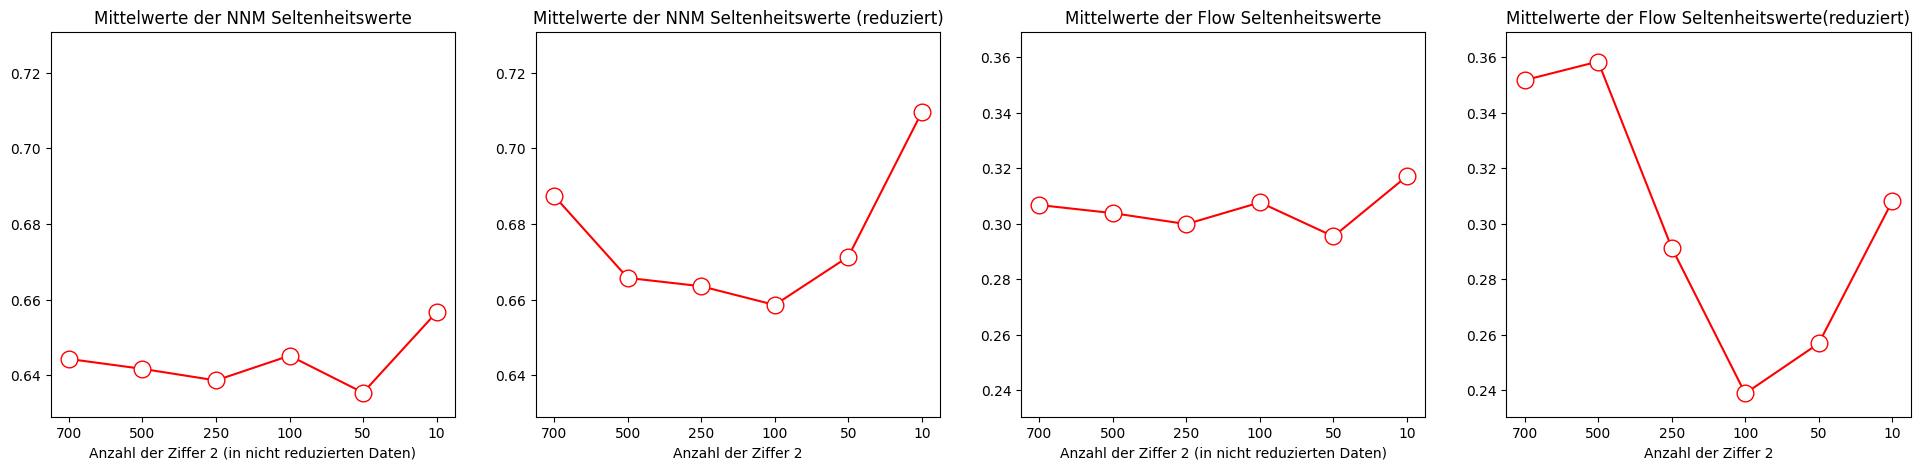

In [603]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Anzahl der Ziffer 2 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.99, max(rarity_scores_red_means)*1.03])


axs[1].plot(rarity_scores_red_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Anzahl der Ziffer 2')
axs[1].set_ylim([min(rarity_scores_means)*0.99, max(rarity_scores_red_means)*1.03])

axs[2].plot(rarity_scores_flow_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit)))
axs[2].set_xticklabels(examples_per_digit)
axs[2].set_xlabel('Anzahl der Ziffer 2 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.78, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte(reduziert)')
axs[3].set_xticks(range(len(examples_per_digit)))
axs[3].set_xticklabels(examples_per_digit)
axs[3].set_xlabel('Anzahl der Ziffer 2')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.78, max(rarity_scores_red_flow_means)*1.03])

(0.2479308614328141, 0.6682555168102489)

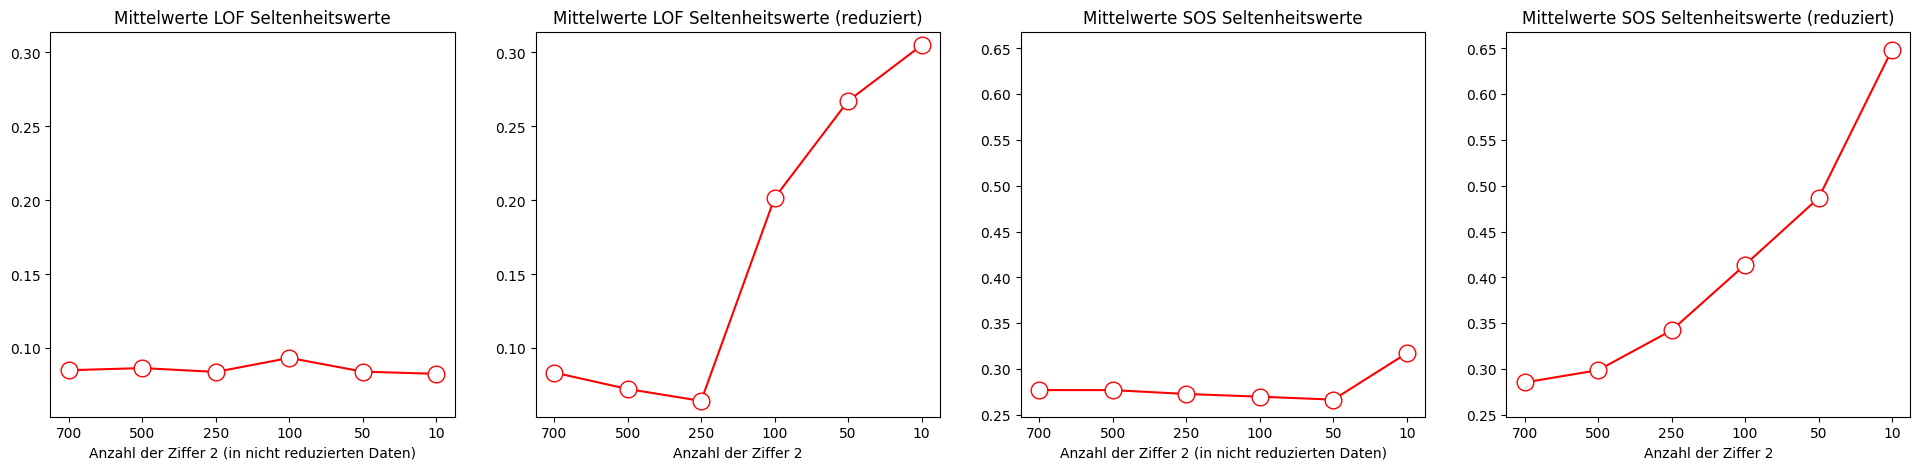

In [604]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_lof_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Anzahl der Ziffer 2 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.65, max(rarity_scores_red_lof_means)*1.03])

axs[1].plot(rarity_scores_red_lof_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Anzahl der Ziffer 2')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.65, max(rarity_scores_red_lof_means)*1.03])

axs[2].plot(rarity_scores_sos_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit)))
axs[2].set_xticklabels(examples_per_digit)
axs[2].set_xlabel('Anzahl der Ziffer 2 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.03])

axs[3].plot(rarity_scores_red_sos_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit)))
axs[3].set_xticklabels(examples_per_digit)
axs[3].set_xlabel('Anzahl der Ziffer 2')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.03])

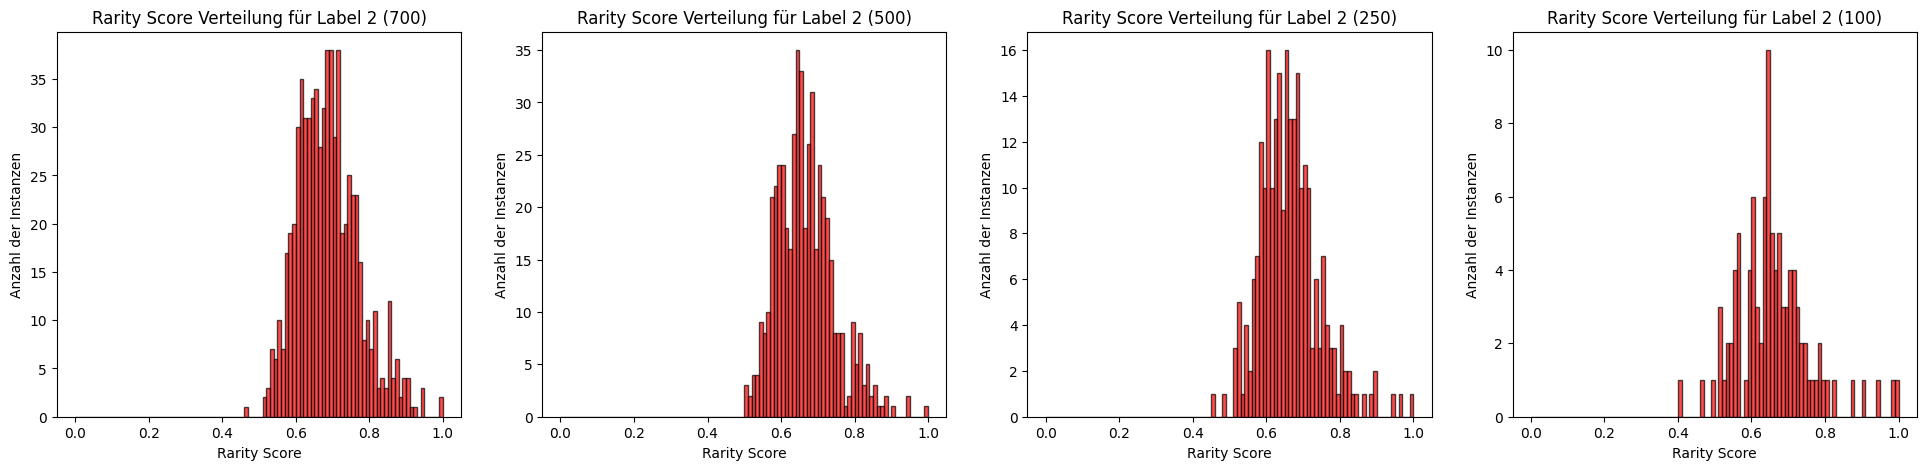

In [558]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Histogramm für normale Rarity Scores
axs[0].hist(rarity_scores_reduced_two[0][y_reduced_list_two[0] == 2], range=[0, 1], bins=100, color='r', edgecolor='black', alpha=0.7)
axs[0].set_title('Rarity Score Verteilung für Label 2 (700)')
axs[0].set_xlabel('Rarity Score')
axs[0].set_ylabel('Anzahl der Instanzen')

# Histogramm für reduzierte Rarity Scores
axs[1].hist(rarity_scores_reduced_two[1][y_reduced_list_two[1] == 2], range=[0, 1], bins=100, color='r', edgecolor='black', alpha=0.7)
axs[1].set_title('Rarity Score Verteilung für Label 2 (500)')
axs[1].set_xlabel('Rarity Score')
axs[1].set_ylabel('Anzahl der Instanzen')

# Histogramm für Flow Rarity Scores
axs[2].hist(rarity_scores_reduced_two[2][y_reduced_list_two[2] == 2], range=[0, 1], bins=100, color='r', edgecolor='black', alpha=0.7)
axs[2].set_title('Rarity Score Verteilung für Label 2 (250)')
axs[2].set_xlabel('Rarity Score')
axs[2].set_ylabel('Anzahl der Instanzen')

# Histogramm für reduzierte Flow Rarity Scores
axs[3].hist(rarity_scores_reduced_two[3][y_reduced_list_two[3] == 2], range=[0, 1], bins=100, color='r', edgecolor='black', alpha=0.7)
axs[3].set_title('Rarity Score Verteilung für Label 2 (100)')
axs[3].set_xlabel('Rarity Score')
axs[3].set_ylabel('Anzahl der Instanzen')

plt.show()